In [34]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# Load the dataset
df = pd.read_csv("housing.csv")

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [36]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


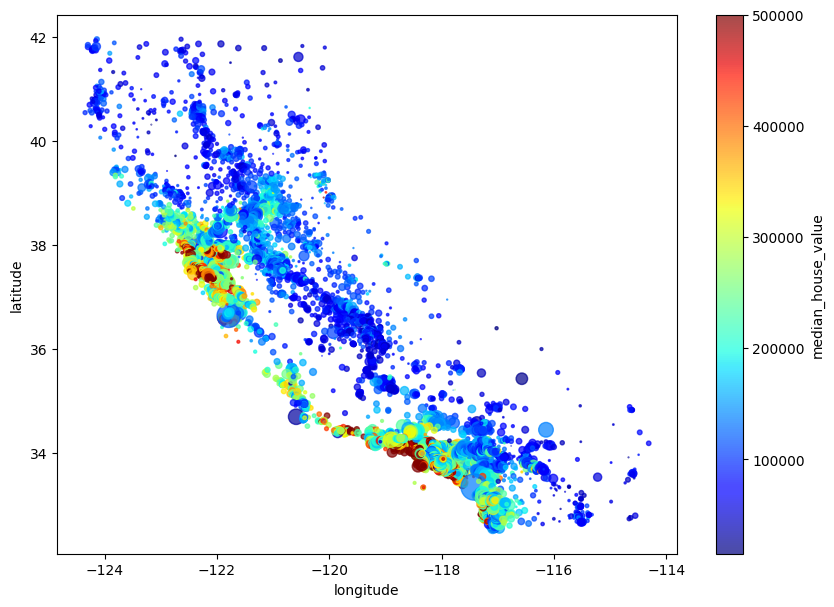

In [37]:
# here i want to show that houses closer to the cities (San Francisco and Los Angeles) are more expensive.
# Used AI to generate this plot, for cities coordinates and to calculate distance using haversine formula.
df.plot(kind="scatter", x="longitude",y="latitude", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7), s=df['population']/100, alpha=0.7)
plt.show()

In [38]:
# I will delete coordinates as they are not good to use for ML models and instead will create  a new column: distance_to_nearest_city. I performed that before in Advanced data analytics course:
# approximate coordinates of 2 biggerst cities. You can see above that houses closer to these cities are more expensive.
sf_coords = (37.7749, -122.4194)  # San Francisco
la_coords = (34.0522, -118.2437)  # Los Angeles

In [39]:
# Use haversine formula (distance in km):

from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [40]:
# Create a column for the shortest distance:

df['distance_to_nearest_city'] = df.apply(
    lambda row: round(min(
        haversine(row['latitude'], row['longitude'], *sf_coords),
        haversine(row['latitude'], row['longitude'], *la_coords)
    ), 2),
    axis=1
)

In [41]:
# now i will drop lon and lat
df = df.drop(columns=['latitude', 'longitude'])
df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,distance_to_nearest_city
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,20.33
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,19.91
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,17.84
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,17.06
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,17.06


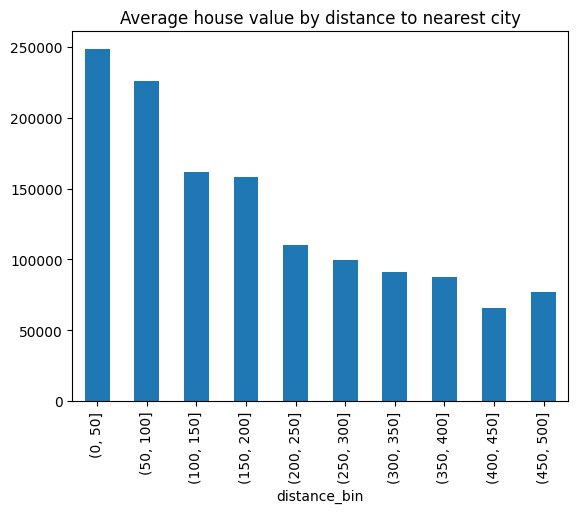

In [42]:
# just to confirm that just created column is correct, i will plot it against median house value.

df_binned = df.copy()
df_binned["distance_bin"] = pd.cut(
    df_binned["distance_to_nearest_city"],
    bins=[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
)

grouped = df_binned.groupby("distance_bin")["median_house_value"].mean()

plt.figure()
grouped.plot(kind="bar",  legend=False)

plt.title("Average house value by distance to nearest city")
plt.show()

# used AI to bin distance to nearest city.


In [43]:
# next I will convert the nominal categories "ocean_proximity" to numbers using OneHotEncoder:
df['ocean_proximity'].unique()

<StringArray>
['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']
Length: 5, dtype: str

In [44]:
# by using encoder we will add 5 new columns, but will remove one -  and the original one.
from sklearn.preprocessing import OneHotEncoder
variables = ['ocean_proximity']

# use encoder
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [45]:
df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,distance_to_nearest_city,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,20.33,0,0,0,1,0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,19.91,0,0,0,1,0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,17.84,0,0,0,1,0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,17.06,0,0,0,1,0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,17.06,0,0,0,1,0


In [46]:
# dropping the last variable:
df = df.drop("ocean_proximity_NEAR OCEAN", axis=1)

In [47]:
# checking missing values
df.isnull().sum()

housing_median_age             0
total_rooms                    0
total_bedrooms               207
population                     0
households                     0
median_income                  0
median_house_value             0
distance_to_nearest_city       0
ocean_proximity_<1H OCEAN      0
ocean_proximity_INLAND         0
ocean_proximity_ISLAND         0
ocean_proximity_NEAR BAY       0
dtype: int64

In [48]:
# drop rows with missing values
df = df.dropna()

In [49]:
# check
df.isnull().sum()

housing_median_age           0
total_rooms                  0
total_bedrooms               0
population                   0
households                   0
median_income                0
median_house_value           0
distance_to_nearest_city     0
ocean_proximity_<1H OCEAN    0
ocean_proximity_INLAND       0
ocean_proximity_ISLAND       0
ocean_proximity_NEAR BAY     0
dtype: int64

In [50]:
# Now dataset is ready to be used for ML models.
df.duplicated().any()

np.False_

<Axes: >

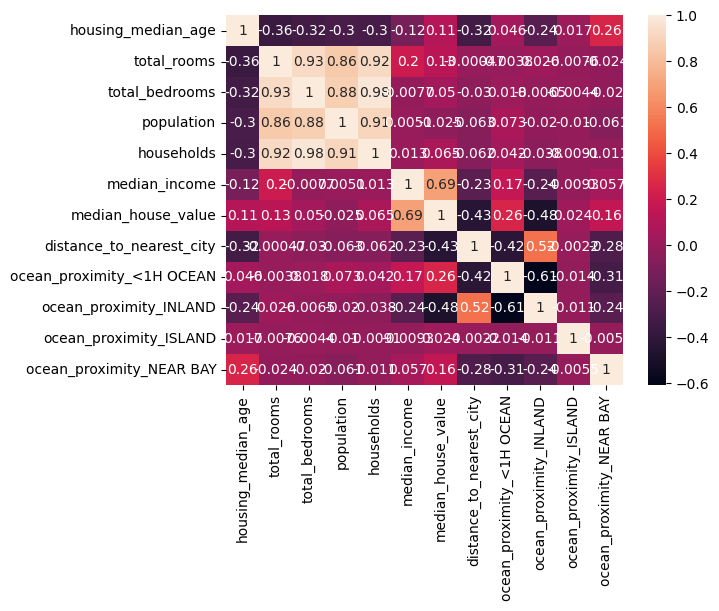

In [51]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

#### We heatmap we can see redundancy for 4 variables:  total_rooms, total_bedrooms, and households, population. I will drop total_bedrooms and households.


In [52]:
columns_to_drop = ['total_bedrooms', 'households']
df = df.drop(columns=columns_to_drop)

In [53]:
df.describe()

,housing_median_age,total_rooms,population,median_income,median_house_value,distance_to_nearest_city,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,28.633094,2636.504233,1424.946949,3.871162,206864.413155,89.803481,0.442128,0.317917,0.000245,0.111095
std,12.591805,2185.269567,1133.208490,1.899291,115435.667099,84.324286,0.496652,0.465678,0.015641,0.314257
min,1.000000,2.000000,3.000000,0.499900,14999.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,1450.000000,787.000000,2.563700,119500.000000,22.810000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,2127.000000,1166.000000,3.536500,179700.000000,57.990000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,3143.000000,1722.000000,4.744000,264700.000000,140.190000,1.000000,1.000000,0.000000,0.000000
max,52.000000,39320.000000,35682.000000,15.000100,500001.000000,489.120000,1.000000,1.000000,1.000000,1.000000


In [54]:
# save this cleaned version to a csv-file
df.to_csv("housing_pre_target_trim.csv", index=None)

In [55]:
# I will drop rows with value more than 500001, as it will be too much outliers.
# i checked result of Ransac without dropping these rows - Inliers: 19552 Outliers: 881
# with deleting : Inliers:17523, Outliers: it changed from 10102 to 1952. So, without dropping rows the amount of outliers are less, what is very strange. 
# P.S. After all I decided to drop rows with value more than 500001, 
# because after all the optimization steps median_house_value still had big dump on 500001 value, what is not good for ML models. 
# I will save the df before deleting these rows, because it can be useful for some models, which are not sensitive to outliers. 


df = df[df['median_house_value'] < 500001]

In [56]:
df.head()

,housing_median_age,total_rooms,population,median_income,median_house_value,distance_to_nearest_city,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY
0,41.0,880.0,322.0,8.3252,452600.0,20.33,0,0,0,1
1,21.0,7099.0,2401.0,8.3014,358500.0,19.91,0,0,0,1
2,52.0,1467.0,496.0,7.2574,352100.0,17.84,0,0,0,1
3,52.0,1274.0,558.0,5.6431,341300.0,17.06,0,0,0,1
4,52.0,1627.0,565.0,3.8462,342200.0,17.06,0,0,0,1


In [57]:
df.describe()

,housing_median_age,total_rooms,population,median_income,median_house_value,distance_to_nearest_city,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY
count,19475.000000,19475.000000,19475.000000,19475.000000,19475.000000,19475.000000,19475.000000,19475.000000,19475.000000,19475.000000
mean,28.378074,2620.491142,1440.290732,3.676739,192444.651913,92.166671,0.436714,0.332169,0.000257,0.106650
std,12.515373,2184.938093,1144.399323,1.569263,97702.625782,85.222150,0.495991,0.471004,0.016021,0.308675
min,1.000000,2.000000,3.000000,0.499900,14999.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,1441.000000,796.000000,2.526500,116500.000000,23.420000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,2111.000000,1178.000000,3.451900,173800.000000,60.640000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,3118.000000,1743.000000,4.583300,248100.000000,143.120000,1.000000,1.000000,0.000000,0.000000
max,52.000000,39320.000000,35682.000000,15.000100,500000.000000,489.120000,1.000000,1.000000,1.000000,1.000000


In [58]:
# save this cleaned version to a csv-file
df.to_csv("housing_before_optimization.csv", index=None)

####  Optimization 1: RANSAC for undersampling / noise / outlier removal

In [59]:
from sklearn.linear_model import RANSACRegressor

# RANSAC was already implemented in previours course, so i will use code from there.
#(https://github.com/RovSveta/Advanced_Data_analytics_2025/blob/27a5219bfaf792b6d66f39fb35fb91968ca79c77/Exercise_project_2/Regression_dataset/ransac_regression.ipynb)


# X/y -split
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]


In [60]:
# Apply RANSAC:
# initalize RANSAC regressor and fit our data
# RANSAC needs a threshold in order to process data
# since our data is heavily skewed, we're gonna use this trick
ransac = RANSACRegressor(residual_threshold=np.std(y) * 1.5)
ransac.fit(X, y)

# now we have split the result into 
# inliers and outliers
# inliers => good data, follows the distribution nicely
# outliers => are far away from the main distribution
# the ~-sign (tilde) in pandas DataFrames means "the opposite of"
# so in this case => get everything from DataFrame EXCEPT the inliers
inlier_mask = ransac.inlier_mask_
outliers = df[~inlier_mask]
inliers = df[inlier_mask]

print(f"Inliers: {len(inliers)}")
print(f"Outliers: {len(outliers)}")

df = inliers

Inliers: 18215
Outliers: 1260


####  Optimization 2: MAD for further noise removal

In [61]:
variable = "median_income"

# Calculate the median
median = df[variable].median()

# Calculate MAD
mad = np.median(np.abs(df[variable] - median))

# Define a threshold for noise detection
# adjust the numeric modifier for aggressiveness 
# e.g. try 2.5 or 4.5 etc.
# if the value is too high, you will find no noise (decrease in that case)
threshold = 3.5 * mad

# Detect noise
noise = df[np.abs(df[variable] - median) > threshold]

inliers = df.drop(noise.index)

print(f"Detected noise using MAD: {len(noise)} rows")
noise

# we want to keep only the inliers (non-noisy data)
# replace the current DataFrame with the inliers
df = inliers

Detected noise using MAD: 506 rows


####  Optimization 3: Isolation Forest for outlier removal

In [62]:
# can process the whole dataset 
# and compares variables to each other instead
# of focusing on outliers on a single variable
from sklearn.ensemble import IsolationForest
import pandas as pd

# adjust the contamination rate as you see fit
# for example, if you expect 5% of the data to be outliers
# you can use 0.05 etc. 

# basically, this is how aggressive Isolation Forest will be
# increase if you think you need to detect more outliers
# decrease if you need less outliers
iso = IsolationForest(contamination=0.06) 

# REMEMBER! Isolation Forest is a machine learning algorithm
# => ALL VARIABLES HAVE TO BE NUMERIC AT THIS POINT

# fit isolation forest
y_pred = iso.fit_predict(df)

# separate outliers and inliers into separate DataFrames
outliers = df[y_pred != 1]
inliers = df[y_pred == 1]

print(f"Inliers: {len(inliers)}")
print(f"Outliers: {len(outliers)}")

# we want to keep only the inliers (non-noisy data)
# replace the current DataFrame with the inliers
df = inliers

Inliers: 16646
Outliers: 1063


<Axes: xlabel='median_house_value', ylabel='Count'>

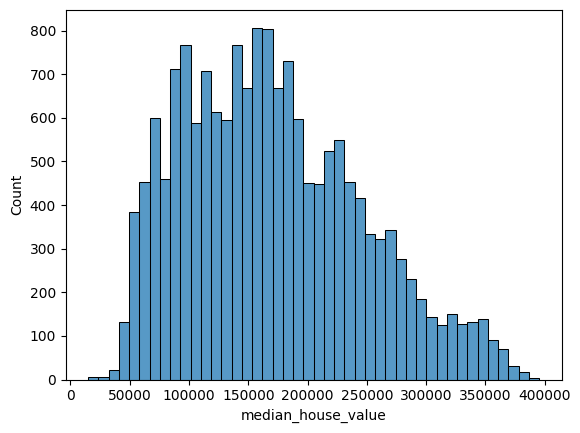

In [63]:
sns.histplot(df['median_house_value'])

<Axes: xlabel='median_income', ylabel='Count'>

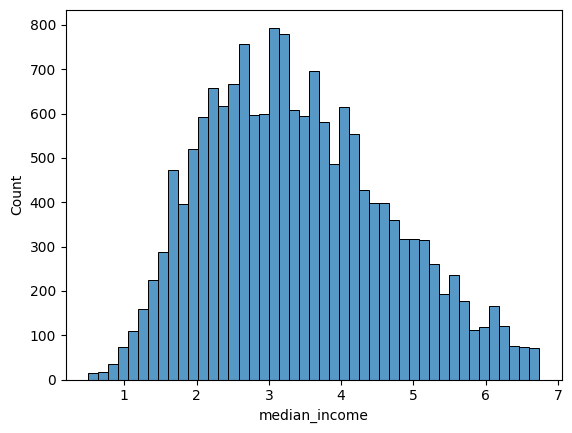

In [64]:
sns.histplot(df['median_income'])

<Axes: xlabel='total_rooms', ylabel='Count'>

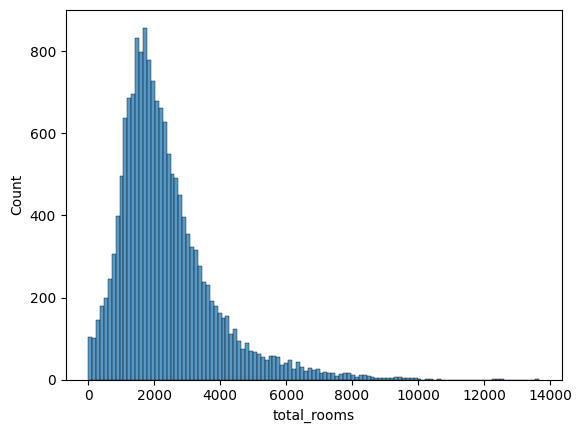

In [65]:
sns.histplot(df['total_rooms'])

<Axes: xlabel='population', ylabel='Count'>

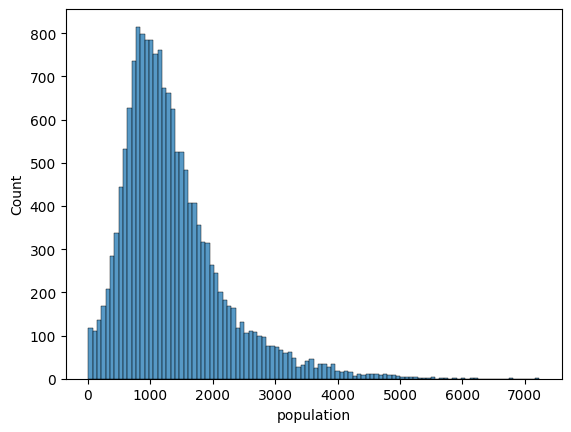

In [66]:
sns.histplot(df['population'])

In [67]:
df.describe()

,housing_median_age,total_rooms,population,median_income,median_house_value,distance_to_nearest_city,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY
count,16646.000000,16646.000000,16646.000000,16646.000000,16646.000000,16646.000000,16646.000000,16646.000000,16646.000000,16646.000000
mean,28.525952,2365.672954,1355.588670,3.403200,170451.285354,96.937193,0.448036,0.361889,0.000120,0.069386
std,11.956154,1443.732793,812.110795,1.259225,75183.944439,87.019340,0.497307,0.480561,0.010961,0.254117
min,1.000000,2.000000,6.000000,0.499900,14999.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,1424.000000,809.000000,2.437500,110500.000000,24.422500,0.000000,0.000000,0.000000,0.000000
50%,29.000000,2048.000000,1181.000000,3.262350,162500.000000,68.540000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,2949.000000,1701.750000,4.238600,222000.000000,155.067500,1.000000,1.000000,0.000000,0.000000
max,52.000000,13670.000000,7228.000000,6.739500,395300.000000,489.120000,1.000000,1.000000,1.000000,1.000000


In [68]:
# save this cleaned version to a csv-file
df.to_csv("processed_regression_housing.csv", index=None)